# Libraries

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import words,stopwords
from nltk.tokenize import word_tokenize

nltk.download('words')
nltk.download('punkt')

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report,
    precision_recall_curve
)

from imblearn.over_sampling import SMOTE
import joblib
import matplotlib.cm as cm

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

from imblearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Importing cleaned datasets

In [2]:
# Load cleaned dataset
df = pd.read_csv(r"final_cleaned_translation_data.csv")

# Display the first 5 entries of the DataFrame
df.head(5)

,Unnamed: 0,clean_text,translated_text,tokenize_text,Mood
0,0,innovation officially open click learn tech ja...,innovation officially open click learn tech ja...,"['innovation', 'officially', 'open', 'click', ...",0
1,1,open asia pacific seoul region aresysadmin,open asia pacific seoul region aresysadmin,"['open', 'asia', 'pacific', 'seoul', 'region',...",0
2,2,beginners guide scaling million users amazons ...,beginners guide scaling million users amazons ...,"['beginners', 'guide', 'scaling', 'million', '...",0
3,3,bridging azure environments aresysadmin,bridging azure environments aresysadmin,"['bridging', 'azure', 'environments', 'aresysa...",0
4,4,elasticsearch service elasticbeanstalk laravel...,elasticsearch service elasticbeanstalk laravel...,"['elasticsearch', 'service', 'elasticbeanstalk...",0


In [3]:
# Filter and check rows where 'translated_text' is an empty list
df_empty = df[df['translated_text'].apply(lambda x: isinstance(x, list) and len(x) == 0)]

# Display the filtered rows
print(df_empty)

# Preprocessing functions
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    tokens = nltk.word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return " ".join(tokens)

df['translated_text'] = df['translated_text'].apply(preprocess_text)

# Remove rows with empty strings or strings containing only '[]'
df = df[df['translated_text'].str.strip() != '']
df = df[df['translated_text'] != '[]']

Empty DataFrame
Columns: [Unnamed: 0, clean_text, translated_text, tokenize_text, Mood]
Index: []


# Modeling

This distribution is imbalanced for modeling because the classes (moods) are not represented equally.
- The 'Neutral' class significantly outweighs both the 'Positive' and 'Negative' classes. The imbalance is particularly notable between 'Neutral' and 'Negative', where 'Neutral' is about 12 times more frequent than 'Negative'.
- Such imbalances can lead to biased models that favor the majority class ('Neutral') and may perform poorly on the minority classes ('Positive' and 'Negative'). This is because the model might learn to predict the majority class more often, as it minimizes overall error but may fail to capture the patterns in the minority classes.
- Traditional performance metrics like accuracy can be misleading in imbalanced datasets, as a model predicting only the majority class could still achieve high accuracy.

To address this imbalance, techniques such as resampling (e.g. SMOTE), class weighting, or using specialized metrics (e.g. Precision, Recall,F1 score) should be considered to improve model performance across all classes.

In [4]:
df['Mood'].value_counts()

Mood
0    63917
1    26446
2     5275
Name: count, dtype: int64

C:\Users\admin\AppData\Local\Temp\ipykernel_22952\1427554676.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(mood_counts))


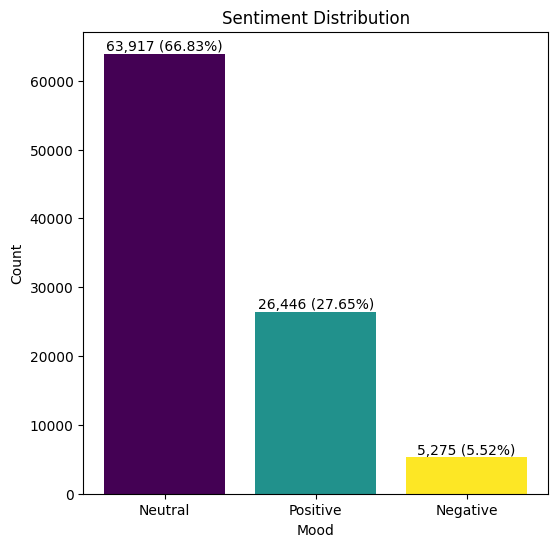

In [5]:
# Count the occurrences of each mood
mood_counts = df['Mood'].value_counts().sort_index()

# Map the mood numbers to labels
mood_labels = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}
mood_counts.index = mood_counts.index.map(mood_labels)

# Define colors using 'viridis' colormap
cmap = cm.get_cmap('viridis', len(mood_counts))
colors = [cmap(i) for i in range(len(mood_counts))]

# Calculate percentages
total_count = mood_counts.sum()
mood_percentages = (mood_counts / total_count) * 100

# Create a bar plot
plt.figure(figsize=(6, 6))
bars = plt.bar(mood_counts.index, mood_counts.values, color=colors)
plt.title('Sentiment Distribution')
plt.xlabel('Mood')
plt.ylabel('Count')

# Add value annotations on the bars with comma formatting and percentages
for bar, percentage in zip(bars, mood_percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height, f'{int(height):,} ({percentage:.2f}%)',
             ha='center', va='bottom')

plt.show()

### Splitting the data to training data and test data
- Set stratify=y in train_test_split, it ensures that the class distribution in the training and testing sets is the same as in the original dataset. For example, if your original dataset has 66% 'Neutral', 27% 'Positive', and 15% 'Negative' samples, the training and testing sets will also have approximately the same proportions of these classes.  This helps to ensure that the model is trained and tested on representative samples of the data, avoiding biases that could arise from having different class distributions in the training and testing sets. Avoiding biases means preventing the situation where the model might perform well on some classes but poorly on others due to imbalanced representation in the training or testing data.

In [6]:
# Vectorization
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df['translated_text'])
y = df['Mood']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# Display shapes of the resulting datasets
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (76510, 29343)
X_test shape: (19128, 29343)
y_train shape: (76510,)
y_test shape: (19128,)


### How SMOTE (Synthetic Minority Over-sampling Technique) in our dataset:
- The number of examples for each mood is not equal. 'Neutral' has a lot more examples compared to 'Positive' and 'Negative'.
- When you train a machine learning model on this imbalanced data, the model can become biased. This means it might not learn to recognize 'Positive' and 'Negative' moods very well because it sees 'Neutral' much more often.
- SMOTE helps by creating new examples of the less common moods ('Positive' and 'Negative') to balance things out. It looks at the existing 'Positive' and 'Negative' examples and creates new, similar ones by mixing them together.
- By adding these new, synthetic examples to your dataset, SMOTE makes sure that each mood has roughly the same number of examples. This helps the machine learning model learn to recognize all moods equally well.
- synthetic example refers to a new, artificial data point that is generated to balance the dataset. 
- How it generate new data points: For each example in the minority class, SMOTE selects one or more of its nearest neighbors (other similar examples in the minority class).



In [7]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Convert resampled data back to text form
resampled_text = tfidf_vectorizer.inverse_transform(X_train_resampled)
resampled_text = [" ".join(text) for text in resampled_text]

# Create a DataFrame
resampled_df = pd.DataFrame({'translated_text': resampled_text, 'Mood': y_train_resampled})

print(f"Original shape: {df.shape}")
print(f"Resampled shape: {resampled_df.shape, y_train_resampled.shape}")
print(resampled_df.head())

Original shape: (95638, 5)
Resampled shape: ((153399, 2), (153399,))
                                     translated_text  Mood
0                         frankfurt available lambda     0
1  makefile heres deployment beanstalk elastic co...     0
2                                          certified     0
3               wsgi zappa serverless gateway lambda     0
4  centr ifttt tuesday register server next time ...     0


In [8]:
resampled_df['Mood'].value_counts()

Mood
0    51133
1    51133
2    51133
Name: count, dtype: int64

In [25]:
resampled_df.to_csv("balanced_dataset.csv",index=True)

In [9]:
resampled_df

,translated_text,Mood
0,frankfurt available lambda,0
1,makefile heres deployment beanstalk elastic co...,0
2,certified,0
3,wsgi zappa serverless gateway lambda,0
4,centr ifttt tuesday register server next time ...,0
...,...,...
153394,noneg canadians ineg pneg hneg securityneg ana...,2
153395,notneg thats isnt perfect least toneg noneg an...,2
153396,roadshow cloud dont computing problem fans kic...,2
153397,google cloud says cuts prices lower even compa...,2


- Now, our training data is balanced, meaning it has a similar number of 'Neutral', 'Positive', and 'Negative' examples. This helps our model learn to identify all three moods more accurately.

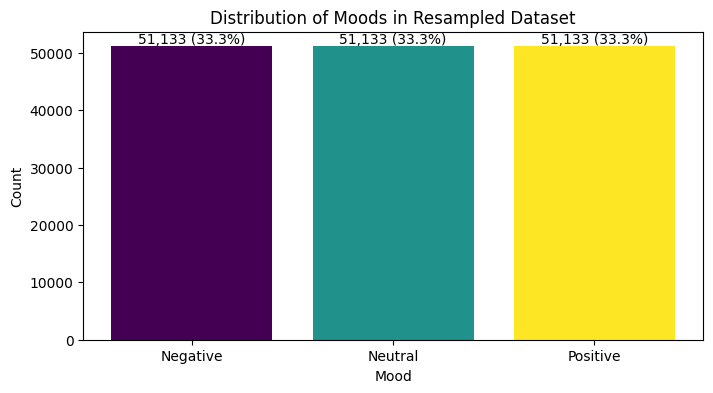

In [10]:
# 1. Convert resampled data to DataFrame and map labels to descriptive names
mood_mapping = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}
r_df = pd.DataFrame({'Mood': y_train_resampled})
r_df['Mood'] = r_df['Mood'].map(mood_mapping)

# 2. Count the occurrences of each mood
mood_counts = r_df['Mood'].value_counts().sort_index()

# 3. Define pastel colors
colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(mood_counts)))

# 4. Create a bar plot
plt.figure(figsize=(8, 4))
bars = plt.bar(mood_counts.index, mood_counts.values, color=colors)
plt.title('Distribution of Moods in Resampled Dataset')
plt.xlabel('Mood')
plt.ylabel('Count')

# 5. Add value annotations on the bars with comma formatting and percentages
total_count = sum(mood_counts.values)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height, f'{int(height):,} ({height/total_count:.1%})',
             ha='center', va='bottom')

plt.show()


###  Model training, validation and evaluation procedures

In [12]:
# Convert the resampled text data back to TF-IDF features
X_train_resampled_tfidf = tfidf_vectorizer.transform(resampled_df['translated_text'])
y_train_resampled = resampled_df['Mood']

# Define the models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)  
}

# Train, predict, and evaluate each model
for model_name, model in models.items():
    model.fit(X_train_resampled_tfidf, y_train_resampled)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
    
    print(f"\n{model_name} Results:")
    print(classification_report(y_test, y_pred))
 


Random Forest Results:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     12784
           1       0.94      0.89      0.92      5289
           2       0.86      0.72      0.78      1055

    accuracy                           0.94     19128
   macro avg       0.92      0.86      0.89     19128
weighted avg       0.94      0.94      0.94     19128


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     12784
           1       0.90      0.89      0.89      5289
           2       0.75      0.76      0.75      1055

    accuracy                           0.92     19128
   macro avg       0.86      0.86      0.86     19128
weighted avg       0.92      0.92      0.92     19128


XGBoost Results:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     12784
           1       0.91      0.77      0.83      5289
   

# Cross-validation

Cross-validation is a technique used to evaluate the performance of a model by splitting the data into multiple folds.
This process helps in evaluating the performance of the model while handling class imbalance and ensuring reproducibility through the use of random states.

Model training and evaluation, where in each fold, the model is trained on the training set and evaluated on the test set. This process is repeated for all folds, and the performance metrics are averaged to get an overall assessment.

Random Forest Cross-validation

In [14]:
# Define the pipeline with Random Forest
rf_model = RandomForestClassifier(random_state=42)
SMOTE_pipeline_rf = make_pipeline(smote, rf_model)

def model_cv(splits, X, Y, pipeline, average_method):
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy, precision, recall, f1 = [], [], [], []
    
    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # Fit the model on the training set
        model_fit = pipeline.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model_fit.predict(X_test)
        
        # Calculate scores
        accuracy.append(model_fit.score(X_test, y_test) * 100)
        precision.append(precision_score(y_test, y_pred, average=average_method) * 100)
        recall.append(recall_score(y_test, y_pred, average=average_method) * 100)
        f1.append(f1_score(y_test, y_pred, average=average_method) * 100)
        
        # Print individual fold scores for debugging purposes
        print('              negative    neutral     positive')
        print('precision:', precision_score(y_test, y_pred, average=None))
        print('recall:   ', recall_score(y_test, y_pred, average=None))
        print('f1 score: ', f1_score(y_test, y_pred, average=None))
        print('-'*50)
    
    # Print overall scores
    print("accuracy: %.2f%%" % np.mean(accuracy))
    print("precision: %.2f%%" % np.mean(precision))
    print("recall: %.2f%%" % np.mean(recall))
    print("f1 score: %.2f%%" % np.mean(f1))

# Perform cross-validation
model_cv(5, X_train_resampled_tfidf, y_train_resampled, SMOTE_pipeline_rf, 'macro')


              negative    neutral     positive
precision: [0.95833333 0.98086124 0.99061767]
recall:    [0.97604381 0.96215899 0.9911989 ]
f1 score:  [0.96710749 0.97142011 0.9909082 ]
--------------------------------------------------
              negative    neutral     positive
precision: [0.95713599 0.97801433 0.99100068]
recall:    [0.97379486 0.96137297 0.99061308]
f1 score:  [0.96539356 0.96962225 0.99080685]
--------------------------------------------------
              negative    neutral     positive
precision: [0.95790485 0.98034521 0.99024581]
recall:    [0.9745771  0.96088402 0.99266647]
f1 score:  [0.96616906 0.97051706 0.99145466]
--------------------------------------------------
              negative    neutral     positive
precision: [0.95648826 0.97756953 0.98869506]
recall:    [0.97164092 0.95883446 0.99198201]
f1 score:  [0.96400505 0.96811136 0.99033581]
--------------------------------------------------
              negative    neutral     positive
precision

Logistic Regression Cross-validation

In [15]:
# Define the pipeline with Logistic Regression
log_reg_model = LogisticRegression(random_state=42, max_iter=10000)
SMOTE_pipeline_log_reg = make_pipeline(smote, log_reg_model)

def model_cv(splits, X, Y, pipeline, average_method):
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy, precision, recall, f1 = [], [], [], []
    
    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # Fit the model on the training set
        model_fit = pipeline.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model_fit.predict(X_test)
        
        # Calculate scores
        accuracy.append(model_fit.score(X_test, y_test) * 100)
        precision.append(precision_score(y_test, y_pred, average=average_method) * 100)
        recall.append(recall_score(y_test, y_pred, average=average_method) * 100)
        f1.append(f1_score(y_test, y_pred, average=average_method) * 100)
        
        # Print individual fold scores for debugging purposes
        print('              negative    neutral     positive')
        print('precision:', precision_score(y_test, y_pred, average=None))
        print('recall:   ', recall_score(y_test, y_pred, average=None))
        print('f1 score: ', f1_score(y_test, y_pred, average=None))
        print('-'*50)
    
    # Print overall scores
    print("accuracy: %.2f%%" % np.mean(accuracy))
    print("precision: %.2f%%" % np.mean(precision))
    print("recall: %.2f%%" % np.mean(recall))
    print("f1 score: %.2f%%" % np.mean(f1))

# Perform cross-validation
model_cv(5, X_train_resampled_tfidf, y_train_resampled, SMOTE_pipeline_log_reg, 'macro')

              negative    neutral     positive
precision: [0.93846304 0.95240934 0.9767397 ]
recall:    [0.94094065 0.93732277 0.98963427]
f1 score:  [0.93970021 0.94480583 0.9831447 ]
--------------------------------------------------
              negative    neutral     positive
precision: [0.94186615 0.95600239 0.97422829]
recall:    [0.94260291 0.93917465 0.99061308]
f1 score:  [0.94223439 0.94751381 0.98235237]
--------------------------------------------------
              negative    neutral     positive
precision: [0.94285434 0.95447332 0.97306656]
recall:    [0.94054953 0.94103266 0.98914638]
f1 score:  [0.94170052 0.94770534 0.98104059]
--------------------------------------------------
              negative    neutral     positive
precision: [0.93943525 0.95734266 0.97230769]
recall:    [0.94347741 0.93702943 0.98875526]
f1 score:  [0.94145199 0.94707714 0.9804625 ]
--------------------------------------------------
              negative    neutral     positive
precision

XGBoost cross validation

In [13]:
# Define the pipeline with XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
SMOTE_pipeline_xgb = make_pipeline(smote, xgb_model)

def model_cv(splits, X, Y, pipeline, average_method):
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy, precision, recall, f1 = [], [], [], []
    
    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # Fit the model on the training set
        model_fit = pipeline.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model_fit.predict(X_test)
        
        # Calculate scores
        accuracy.append(model_fit.score(X_test, y_test) * 100)
        precision.append(precision_score(y_test, y_pred, average=average_method) * 100)
        recall.append(recall_score(y_test, y_pred, average=average_method) * 100)
        f1.append(f1_score(y_test, y_pred, average=average_method) * 100)
        
        # Print individual fold scores for debugging purposes
        print('              negative    neutral     positive')
        print('precision:', precision_score(y_test, y_pred, average=None))
        print('recall:   ', recall_score(y_test, y_pred, average=None))
        print('f1 score: ', f1_score(y_test, y_pred, average=None))
        print('-'*50)
    
    # Print overall scores
    print("accuracy: %.2f%%" % np.mean(accuracy))
    print("precision: %.2f%%" % np.mean(precision))
    print("recall: %.2f%%" % np.mean(recall))
    print("f1 score: %.2f%%" % np.mean(f1))

# Perform cross-validation
model_cv(5, X_train_resampled_tfidf, y_train_resampled, SMOTE_pipeline_xgb, 'macro')


              negative    neutral     positive
precision: [0.81702561 0.95904397 0.92529463]
recall:    [0.94221179 0.80825266 0.9290045 ]
f1 score:  [0.87516462 0.87721532 0.92714585]
--------------------------------------------------
              negative    neutral     positive
precision: [0.82206133 0.95854445 0.9274571 ]
recall:    [0.9436785  0.81400352 0.93008702]
f1 score:  [0.87868166 0.88038075 0.9287702 ]
--------------------------------------------------
              negative    neutral     positive
precision: [0.82482877 0.95641202 0.92647345]
recall:    [0.94201623 0.81537258 0.93145595]
f1 score:  [0.87953622 0.88027872 0.92895802]
--------------------------------------------------
              negative    neutral     positive
precision: [0.8249829  0.95700655 0.924842  ]
recall:    [0.9435752  0.81402171 0.93008702]
f1 score:  [0.88030289 0.87974215 0.9274571 ]
--------------------------------------------------
              negative    neutral     positive
precision

Based on these evaluations, we recommend using the Random Forest model for our text classification task due to highest accuracy and balanced performance across all classes, though it has some difficulty with the Negative class. Consider further tuning the Random Forest model or exploring ensemble methods to improve performance, especially for the Negative class OR review the pre-processing steps to ensure the data for the Negative class is well represented and correctly labelled, as this might improve model performance.


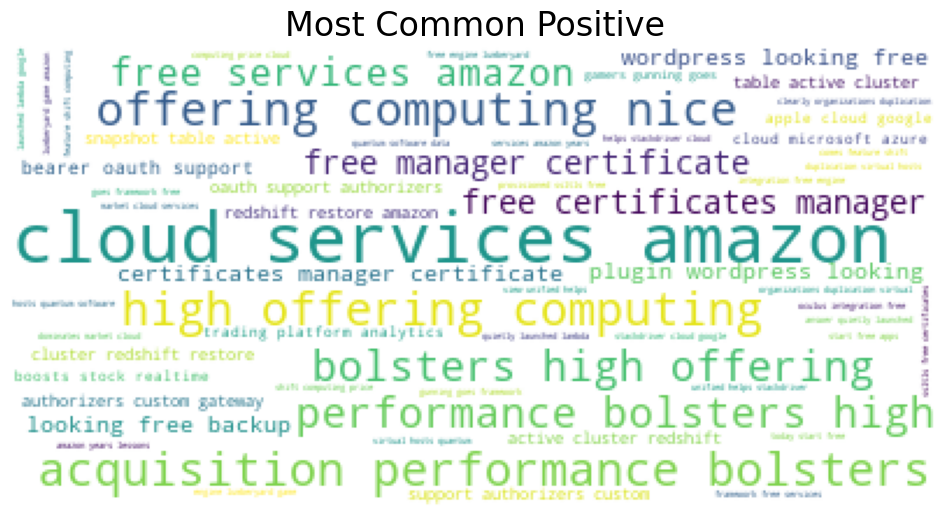

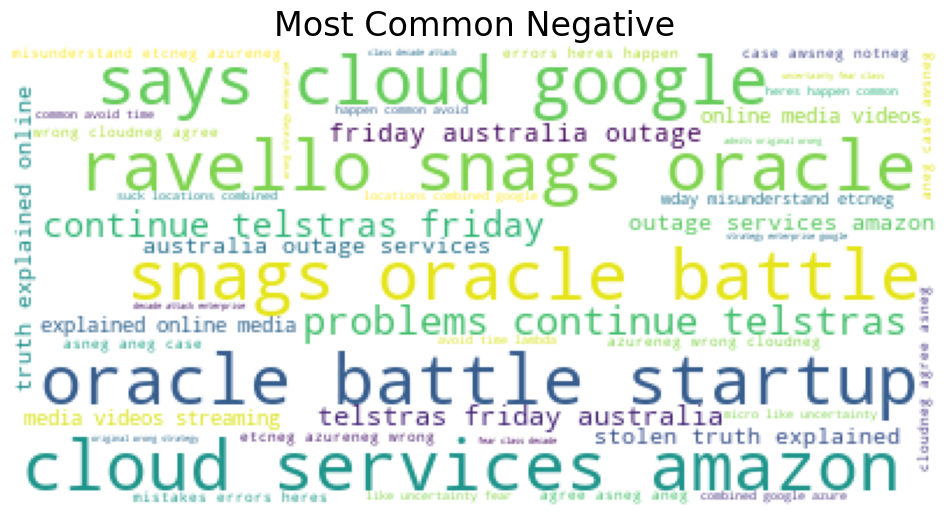

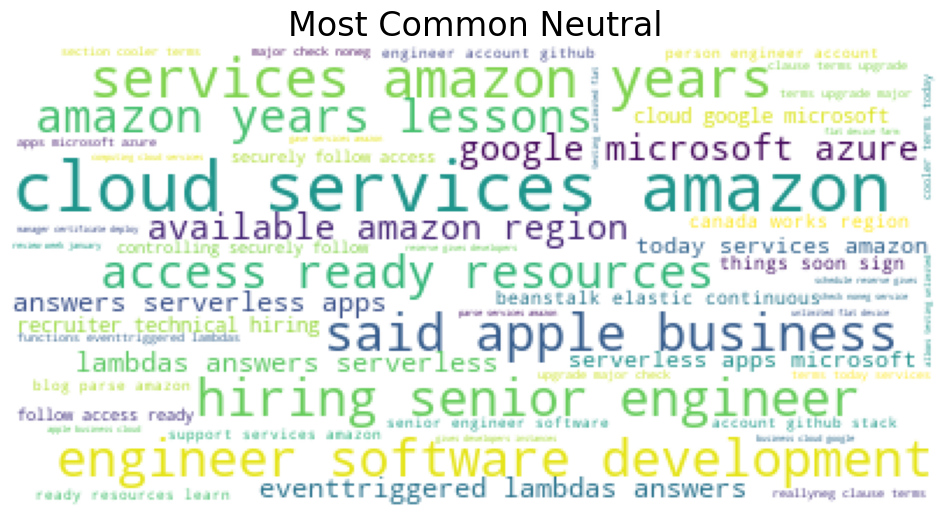

In [55]:
# Function to generate and display a word cloud
def generate_wordcloud(trigrams, sentiment):
    plt.figure(figsize=(12, 8))
    wc = WordCloud(background_color="white", max_words=200, max_font_size=50)
    wc.generate_from_frequencies(trigrams)
    plt.title("Most Common {}".format(sentiment), fontsize=24)
    plt.imshow(wc.recolor(colormap='viridis', random_state=17))
    plt.axis('off')
    plt.show()

# Function to extract trigrams from text
def get_top_trigrams(texts, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return dict(words_freq[:n])

# Use a subset of the dataframe for faster processing
clouds = resampled_df.head(1000)

# Extract trigrams for each sentiment
positive_trigrams = get_top_trigrams(clouds[clouds.Mood == 1]['translated_text'].values)
negative_trigrams = get_top_trigrams(clouds[clouds.Mood == 2]['translated_text'].values)
neutral_trigrams = get_top_trigrams(clouds[clouds.Mood == 0]['translated_text'].values)

# Generate word clouds for each sentiment
generate_wordcloud(positive_trigrams, "Positive")
generate_wordcloud(negative_trigrams, "Negative")
generate_wordcloud(neutral_trigrams, "Neutral")


### Model parameter tuning

In [56]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [60]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)
parameters = {
    'n_estimators': [5,50],
    'max_depth': [2,10,None]
}

cv = GridSearchCV(rf,parameters)
cv.fit(X_train_resampled_tfidf, y_train_resampled)
print_results(cv)

KeyboardInterrupt: 

In [64]:
from sklearn.ensemble import VotingClassifier

lr_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
xg_clf = XGBClassifier()

ensemble_clf = VotingClassifier(estimators=[('log_reg', lr_clf), ("rf_clf",rf_clf), ("xg_clf", xg_clf)])
ensemble_clf

VotingClassifier(estimators=[('log_reg', LogisticRegression()),
                             ('rf_clf', RandomForestClassifier()),
                             ('xg_clf',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))])

In [65]:
ensemble_clf.fit(X_train_resampled, y_resampled)

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('log_reg', LogisticRegression()),
                             ('rf_clf', RandomForestClassifier()),
                             ('xg_clf',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))])

In [66]:
y_pred = ensemble_clf.predict(X_test)

In [67]:
accuracy_score(y_test, y_pred)

0.9165841713124576

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define the models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)  
}

# Function to evaluate the model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr') if y_pred_proba is not None else "N/A"
    
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC Score: {roc_auc}")    
    
# Evaluate each model
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    evaluate_model(model, X_train_resampled, y_train_resampled, X_test, y_test)
    print("\n")

## Model Building - Imbalanced data

In [ ]:
# load library
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

# fit the predictor and target
rfc.fit(X_resampled, y_resampled)

# predict
rfc_predict = rfc.predict(X_test)# check performance
print(classification_report(y_test, rfc_predict))

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Train a classifier on the resampled training set
clf = RandomForestClassifier(random_state=42)
clf.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print classification report
print(classification_report(y_test, y_pred))

# Print additional metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Calculate and print ROC AUC score
# Use 'ovr' (one-vs-rest) strategy for multi-class classification
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()